## Deep Q Network
1. Target Network
2. Double Q network
3. Experience Replay
4. GLIE

In [2]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
%matplotlib inline

from env_simulator import ToyEnv

In [3]:
env = ToyEnv()

In [4]:
n_states = env.observation_space.shape[0]
n_actions = env.action_space.shape[0]
n_episodes = 2000
gamma = 0.98
epsilon = 1
max_steps_per_ep = 100
learning_rate = 0.5
target_q_update_freq = 10
n_samples = 20

In [5]:
class QNetwork():

    def __init__(self, n_states, n_actions):
        self.n_states = n_states
        self.n_actions = n_actions
        self.inputs = tf.placeholder(tf.float32, [None, n_states])
        self.weights = tf.Variable(tf.random_uniform([n_states, n_actions],0,0.01))
        self.outputs = tf.matmul(self.inputs, self.weights)
        self.targets = tf.placeholder(tf.float32, [None, n_actions])

        self.loss = tf.losses.mean_squared_error(self.targets, self.outputs)
        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss)

    def choose_action(self, s, sess, epsilon, state_one_hot):
        prob = [epsilon/self.n_actions]*self.n_actions
        q = sess.run(self.outputs, feed_dict={self.inputs:state_one_hot[s:s+1]})[0].T
        prob[np.argmax(q)] += 1-epsilon
        a = np.random.choice(self.n_actions,1,p=prob)
        return a[0]

In [27]:
def train(exp, qnet, target_qnet):
    batch = np.array(exp).astype(int)
    if n_samples < len(exp):
        batch = np.array(random.sample(batch, n_samples))
    actions = batch[:,1]
    q = sess.run(qnet.outputs, feed_dict={qnet.inputs:encode(batch[:,0])})
    q1 = sess.run(qnet.outputs, feed_dict={qnet.inputs:encode(batch[:,2])})
    tq1 = sess.run(target_qnet.outputs, feed_dict={target_qnet.inputs:encode(batch[:,2])})
    next_actions = np.argmax(q1, axis=-1)
    target = batch[:,-1] + gamma*tq1[np.arange(len(q)), next_actions]
    q[np.arange(len(q)),actions] = target
    sess.run(qnet.optimizer, feed_dict={qnet.inputs:encode(batch[:,0]), qnet.targets:q})

In [29]:
def update_target_net(target_qnet, qnet, sess):
    copy_operation = target_qnet.weights.assign(qnet.weights)
    sess.run(copy_operation)

In [30]:
exp_buffer = []
qnet = QNetwork(n_states, n_actions)
target_qnet = QNetwork(n_states, n_actions)

state_one_hot = np.eye(n_states)
encode = lambda x: state_one_hot[x.astype(int)]

rewards = [] # To hold total reward per episode
avg_rewards = [] # To hold running average of rewards per episode

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for ep in range(n_episodes):
        s,r,done = env.reset()
        n_step = 0
        ep_r = 0
        epsilon = 1.0/(ep+1)
        while not done:
            a = qnet.choose_action(s, sess, epsilon, state_one_hot)
            s1,r,done = env.step(a)
            exp_buffer.append(np.array([s,a,s1,r]))
            s = s1
            train(exp_buffer, qnet, target_qnet)
            ep_r += r
            n_step += 1
            if n_step > max_steps_per_ep:
                break
        rewards.append(ep_r)
        avg_rewards.append(sum(rewards[-500:])/500.0)
        if not ep % 100:
            print("Episode #%d : Reward = %f, Avg Rew = %f" % (ep, ep_r, avg_rewards[-1]))    
        if not ep % target_q_update_freq:
            update_target_net(target_qnet, qnet, sess)

Episode #0 : Reward = 1.000000, Avg Rew = 0.002000
Episode #100 : Reward = 1.000000, Avg Rew = 0.022000
Episode #200 : Reward = -1.000000, Avg Rew = 0.066000
Episode #300 : Reward = 1.000000, Avg Rew = 0.082000
Episode #400 : Reward = -1.000000, Avg Rew = 0.134000
Episode #500 : Reward = -1.000000, Avg Rew = 0.168000
Episode #600 : Reward = 1.000000, Avg Rew = 0.180000
Episode #700 : Reward = 1.000000, Avg Rew = 0.164000
Episode #800 : Reward = 1.000000, Avg Rew = 0.180000
Episode #900 : Reward = 1.000000, Avg Rew = 0.168000
Episode #1000 : Reward = -1.000000, Avg Rew = 0.172000
Episode #1100 : Reward = 1.000000, Avg Rew = 0.164000
Episode #1200 : Reward = 1.000000, Avg Rew = 0.160000
Episode #1300 : Reward = -1.000000, Avg Rew = 0.172000
Episode #1400 : Reward = 1.000000, Avg Rew = 0.180000
Episode #1500 : Reward = -1.000000, Avg Rew = 0.168000
Episode #1600 : Reward = 1.000000, Avg Rew = 0.184000
Episode #1700 : Reward = -1.000000, Avg Rew = 0.216000
Episode #1800 : Reward = -1.00000

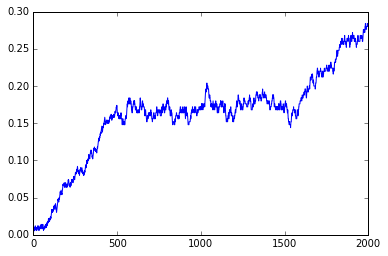

In [31]:
plt.plot(avg_rewards)